In [ ]:
# Ch 0.2.0: PareUNet2DConditionModel

## Part 0: Setup

In [1]:
# Install diffusers
!pip install transformers diffusers accelerate -U
!pip install parediffusers==0.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 93.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 46.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.3.0
    Uninstalling fsspec-2023.3.0:
      Successfully uninstalled fsspec-2023.3.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.1
    Uninstalling huggingface-hub-0.13.1:
      Successfully uninstalled huggingface-hub-0.13.1
  Attempting uninstall: tokenizers
    Found existing installation: toke

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

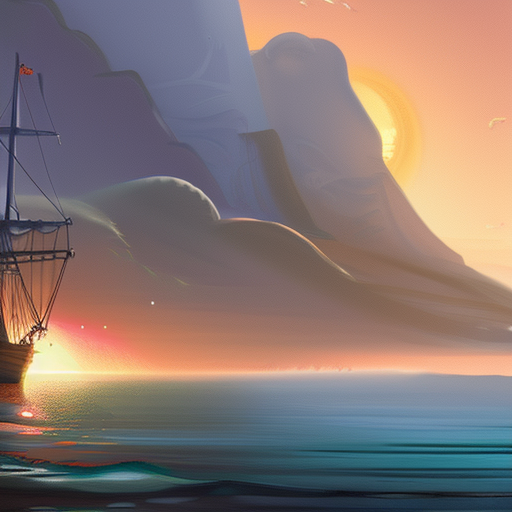

In [ ]:
import torch
from PIL import Image
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from parediffusers import PareDDIMScheduler

from diffusers import UNet2DConditionModel, AutoencoderKL

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = PareDDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			
			# Predict the noise residual for the current timestep
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0][0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image
	

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"
width = 512
height = 512
num_inference_steps = 50

pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()

## Part 2: Get values of UNet

In [3]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(
	device=device, dtype=dtype
)
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleLinear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, b

## Part 3: Check How Works from_pretrained

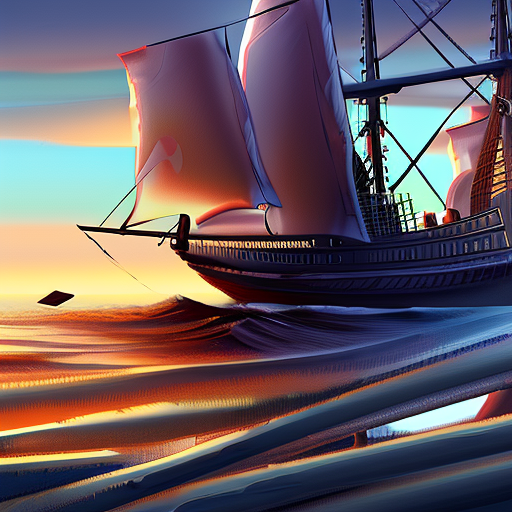

In [31]:
from diffusers.utils import (
	_get_model_file,
	_add_variant,
	WEIGHTS_NAME,
)

def from_pretrained(model_name, **kwargs):
	subfolder = kwargs.pop("subfolder", None)

	user_agent = {
		"diffusers": -1,
		"file_type": "model",
		"framework": "pytorch",
	}

	# load config
	config, unused_kwargs, commit_hash = UNet2DConditionModel.load_config(
		model_name,
		cache_dir=None,
		return_unused_kwargs=True,
		return_commit_hash=True,
		force_download=None,
		resume_download=None,
		proxies=None,
		local_files_only=None,
		token=None,
		revision=None,
		subfolder=subfolder,
		device_map=None,
		max_memory=None,
		offload_folder=None,
		offload_state_dict=None,
		user_agent=user_agent,
		**kwargs,
	)


	model_file = _get_model_file(
		model_name,
		weights_name=_add_variant(WEIGHTS_NAME, None),
		cache_dir=None,
		force_download=None,
		resume_download=None,
		proxies=None,
		local_files_only=None,
		token=None,
		revision=None,
		subfolder=subfolder,
		user_agent=user_agent,
		commit_hash=commit_hash,
	)

	model = UNet2DConditionModel.from_config(config, **unused_kwargs)
	state_dict = torch.load(model_file, map_location="cpu")
	model._convert_deprecated_attention_blocks(state_dict)

	model, _, _, _, _ = UNet2DConditionModel._load_pretrained_model(
		model,
		state_dict,
		model_file,
		model_name,
		ignore_mismatched_sizes=None,
	)
	model.register_to_config(_name_or_path=model_name)
	model.eval()
	return model

pare_unet = from_pretrained("stabilityai/stable-diffusion-2", subfolder="unet").to(
	device=device, dtype=dtype
)
pipe.unet = pare_unet

image = pipe(prompt)
image.show()


### Part 3.1: load_config

In [32]:
import json
from huggingface_hub import hf_hub_download

config_file = hf_hub_download(
	model_name,
	filename="config.json",
	subfolder="unet"
)
with open(config_file, "r", encoding="utf-8") as reader:
    text = reader.read()
config = json.loads(text)

'/root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/1e128c8891e52218b74cde8f26dbfc701cb99d79/unet/config.json'

In [11]:
from diffusers.utils import (
	PushToHubMixin,
	_get_model_file,
	_add_variant,
	WEIGHTS_NAME,
)


model_file = _get_model_file(
	model_name,
	weights_name=_add_variant(WEIGHTS_NAME, None),
	filename="pytorch_model.bin",
	subfolder="unet",
)

TypeError: _get_model_file() missing 9 required keyword-only arguments: 'subfolder', 'cache_dir', 'force_download', 'proxies', 'resume_download', 'local_files_only', 'token', 'user_agent', and 'revision'

In [8]:
import numpy as np
import torch

class ParedDDIMScheduler:
	def __init__(
		self,
		scheduler
	):
		self.config = scheduler.config

		self.betas = scheduler.betas
		self.alphas = 1.0 - self.betas
		self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
		self.final_alpha_cumprod = torch.tensor(1.0)

	def set_timesteps(self, num_inference_steps, device=None):
		self.num_inference_steps = num_inference_steps
		step_ratio = self.config.num_train_timesteps // self.num_inference_steps
		timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
		timesteps += self.config.steps_offset
		self.timesteps = torch.from_numpy(timesteps).to(device)

	def step(
		self,
		model_output: torch.FloatTensor,
		timestep: int,
		sample: torch.FloatTensor,
	):
		prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

		alpha_prod_t = self.alphas_cumprod[timestep]
		alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

		beta_prod_t = 1 - alpha_prod_t

		pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
		pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample

		pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
		prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

		return prev_sample, pred_original_sample

pared_scheduler = ParedDDIMScheduler(scheduler)	

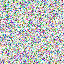

In [9]:
latents = pipe.get_latent(width, height).unsqueeze(dim=0)
latent_model_input = torch.cat([latents] * 2)

guidance_scale = 7.5
pared_scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pared_scheduler.timesteps
t = timesteps[0]

# Predict the noise residual for the current timestep
noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
uncond_residual, text_cond_residual = noise_residual.chunk(2)
guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

latents = pared_scheduler.step(guided_noise_residual, t, latents)[0]
display(pipe.tensor_to_image(latents[0]))

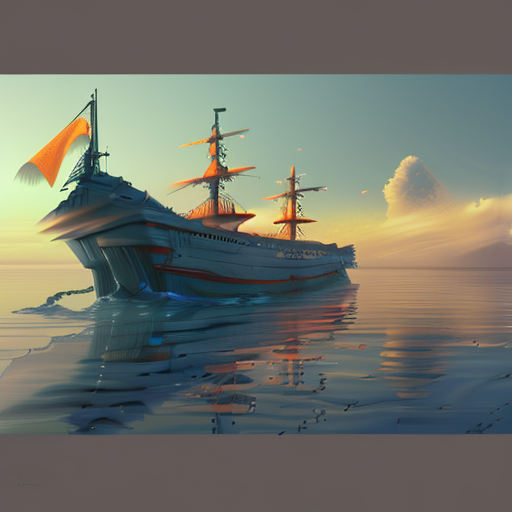

In [10]:
pipe.scheduler = pared_scheduler

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()

## Part 4: Display step of the Scheduler

In [11]:
timesteps = pared_scheduler.timesteps

latents = pipe.get_latent(width, height).unsqueeze(dim=0)
latent_model_input = torch.cat([latents] * 2)

# Predict the noise residual for the current timestep
noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
uncond_residual, text_cond_residual = noise_residual.chunk(2)
guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

# Define arguments for the scheduler.step() function
model_output = guided_noise_residual
timestep = timesteps[0]
sample = latents


In [12]:
prev_timestep = timestep - pared_scheduler.config.num_train_timesteps // pared_scheduler.num_inference_steps
prev_timestep

tensor(961, device='cuda:0')

In [13]:
alpha_prod_t = pared_scheduler.alphas_cumprod[timestep]
alpha_prod_t_prev = pared_scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else pared_scheduler.final_alpha_cumprod
alpha_prod_t_prev

tensor(0.0073)

In [14]:
beta_prod_t = 1 - alpha_prod_t
pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
pred_original_sample

tensor([[[[-1.0381e+00, -5.6494e-01, -6.7871e-01,  ...,  3.1934e-01,
            7.2021e-02, -5.5859e-01],
          [-3.0811e-01,  2.0093e-01, -1.5625e-02,  ...,  7.1143e-01,
            4.5459e-01, -1.7627e-01],
          [-4.1504e-01, -1.7792e-02, -2.1680e-01,  ...,  1.9604e-01,
            9.4971e-02, -5.0049e-01],
          ...,
          [-1.7881e+00, -1.5928e+00, -1.3662e+00,  ..., -1.7764e+00,
           -1.7852e+00, -1.8271e+00],
          [-1.9453e+00, -1.4688e+00, -1.5586e+00,  ..., -1.7266e+00,
           -1.6289e+00, -1.6348e+00],
          [-2.6973e+00, -2.9258e+00, -2.6465e+00,  ..., -3.0352e+00,
           -2.9648e+00, -3.3047e+00]],

         [[-2.9609e+00, -2.6113e+00, -2.7617e+00,  ..., -2.4883e+00,
           -3.0137e+00, -1.8008e+00],
          [-1.8945e+00, -1.8037e+00, -1.9736e+00,  ..., -1.9609e+00,
           -2.1875e+00, -1.2422e+00],
          [-1.6104e+00, -1.6973e+00, -1.6895e+00,  ..., -1.6699e+00,
           -1.8848e+00, -1.3271e+00],
          ...,
     

In [15]:
pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
pred_epsilon

tensor([[[[-9.7070e-01,  6.6748e-01,  1.1707e-01,  ..., -8.7891e-01,
           -8.2812e-01, -5.7007e-02],
          [-1.3916e+00,  3.6255e-02,  1.4785e+00,  ..., -7.7686e-01,
           -6.9775e-01, -3.8794e-01],
          [-1.1787e+00, -4.8071e-01,  4.8047e-01,  ..., -8.5010e-01,
           -3.1445e-01, -1.2910e+00],
          ...,
          [-5.9082e-01, -1.0020e+00, -1.0371e+00,  ...,  2.7344e-01,
            4.8584e-01,  7.9346e-01],
          [-1.7324e+00, -1.4238e+00,  1.2363e+00,  ..., -4.6558e-01,
            6.8652e-01,  2.7466e-01],
          [ 1.9910e-01,  9.1064e-02,  5.4004e-01,  ...,  1.9031e-01,
            4.8291e-01,  1.1953e+00]],

         [[-6.4502e-01, -3.0176e-01,  1.1182e+00,  ..., -1.1084e+00,
            1.5234e+00, -8.7451e-01],
          [-1.5222e-01, -7.7393e-01,  2.1167e-01,  ...,  9.0283e-01,
            5.0537e-01, -8.6243e-02],
          [ 1.5518e+00,  8.1250e-01, -6.4331e-02,  ...,  5.2197e-01,
           -5.7324e-01, -1.3403e-01],
          ...,
     

In [16]:
pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
pred_sample_direction

tensor([[[[-9.6729e-01,  6.6504e-01,  1.1664e-01,  ..., -8.7549e-01,
           -8.2520e-01, -5.6793e-02],
          [-1.3867e+00,  3.6133e-02,  1.4727e+00,  ..., -7.7393e-01,
           -6.9531e-01, -3.8647e-01],
          [-1.1748e+00, -4.7900e-01,  4.7876e-01,  ..., -8.4717e-01,
           -3.1323e-01, -1.2861e+00],
          ...,
          [-5.8887e-01, -9.9854e-01, -1.0332e+00,  ...,  2.7246e-01,
            4.8413e-01,  7.9053e-01],
          [-1.7266e+00, -1.4189e+00,  1.2314e+00,  ..., -4.6387e-01,
            6.8408e-01,  2.7368e-01],
          [ 1.9836e-01,  9.0759e-02,  5.3809e-01,  ...,  1.8958e-01,
            4.8120e-01,  1.1914e+00]],

         [[-6.4258e-01, -3.0054e-01,  1.1143e+00,  ..., -1.1045e+00,
            1.5176e+00, -8.7109e-01],
          [-1.5161e-01, -7.7100e-01,  2.1094e-01,  ...,  8.9941e-01,
            5.0342e-01, -8.5938e-02],
          [ 1.5459e+00,  8.0957e-01, -6.4087e-02,  ...,  5.2002e-01,
           -5.7129e-01, -1.3354e-01],
          ...,
     

In [17]:
prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
prev_sample

tensor([[[[-1.0557,  0.6167,  0.0587,  ..., -0.8481, -0.8188, -0.1045],
          [-1.4131,  0.0533,  1.4717,  ..., -0.7134, -0.6567, -0.4016],
          [-1.2100, -0.4805,  0.4602,  ..., -0.8306, -0.3052, -1.3291],
          ...,
          [-0.7412, -1.1348, -1.1494,  ...,  0.1208,  0.3318,  0.6348],
          [-1.8926, -1.5439,  1.0986,  ..., -0.6113,  0.5449,  0.1342],
          [-0.0319, -0.1589,  0.3123,  ..., -0.0695,  0.2283,  0.9092]],

         [[-0.8955, -0.5234,  0.8784,  ..., -1.3164,  1.2607, -1.0244],
          [-0.3132, -0.9248,  0.0425,  ...,  0.7319,  0.3169, -0.1919],
          [ 1.4082,  0.6650, -0.2083,  ...,  0.3774, -0.7324, -0.2468],
          ...,
          [ 0.6006, -2.3066,  0.0579,  ..., -1.3115, -0.2825,  0.2078],
          [-0.0519,  2.5117, -1.9561,  ...,  0.2861,  0.1368, -0.9199],
          [-0.0028, -0.5952, -1.0020,  ..., -1.4043, -0.7817, -0.6987]],

         [[ 2.1016,  0.1685,  1.8398,  ..., -1.0898, -1.5488,  0.7910],
          [-1.5137,  1.0605, -

## Part 5: from_config

In [18]:
from huggingface_hub import hf_hub_download

config_file = hf_hub_download(
	model_name,
	filename="scheduler_config.json",
	subfolder="scheduler"
)
config_file

'/root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/1e128c8891e52218b74cde8f26dbfc701cb99d79/scheduler/scheduler_config.json'

In [19]:
import json

with open(config_file, "r", encoding="utf-8") as reader:
	text = reader.read()
config_dict = json.loads(text)
config_dict

{'_class_name': 'DDIMScheduler',
 '_diffusers_version': '0.8.0',
 'beta_end': 0.012,
 'beta_schedule': 'scaled_linear',
 'beta_start': 0.00085,
 'clip_sample': False,
 'num_train_timesteps': 1000,
 'prediction_type': 'v_prediction',
 'set_alpha_to_one': False,
 'skip_prk_steps': True,
 'steps_offset': 1,
 'trained_betas': None}

## Part 6: PareDDIMScheduler

In [20]:
class ConfigClass:
	def __init__(self, **kwargs):
		"""Initialize scheduler with configuration dictionary."""
		for key, value in kwargs.items():
			setattr(self, key, value)

In [21]:
import json
import numpy as np
import torch
from huggingface_hub import hf_hub_download

class PareDDIMScheduler:
	def __init__(
		self,
		config_dict: dict
	):
		"""Initialize beta and alpha values for the scheduler."""
		self.config = ConfigClass(**config_dict)
		self.betas =  torch.linspace(self.config.beta_start**0.5, self.config.beta_end**0.5, self.config.num_train_timesteps, dtype=torch.float32) ** 2
		self.alphas = 1.0 - self.betas
		self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
		self.final_alpha_cumprod = torch.tensor(1.0)
	
	@classmethod
	def from_config(cls, model_name: str, subfolder: str = "scheduler", filename: str = "scheduler_config.json") -> "ParedDDIMScheduler":
		"""Create scheduler instance from configuration file."""
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config_dict = json.loads(text)
		return cls(config_dict)

	def set_timesteps(self, num_inference_steps: int, device: torch.device = None) -> None:
		"""Set the timesteps for the scheduler based on the number of inference steps."""
		self.num_inference_steps = num_inference_steps
		step_ratio = self.config.num_train_timesteps // self.num_inference_steps
		timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
		timesteps += self.config.steps_offset
		self.timesteps = torch.from_numpy(timesteps).to(device)

	def step(
		self,
		model_output: torch.FloatTensor,
		timestep: int,
		sample: torch.FloatTensor,
	) -> list:
		"""Perform a single step of denoising in the diffusion process."""
		prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

		alpha_prod_t = self.alphas_cumprod[timestep]
		alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

		beta_prod_t = 1 - alpha_prod_t
		pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
		pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample

		pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
		prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

		return prev_sample, pred_original_sample


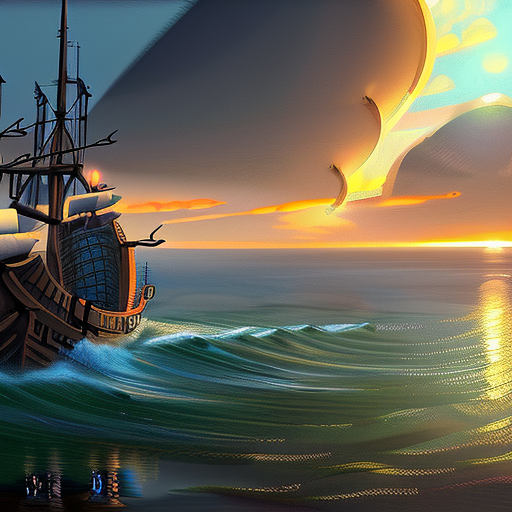

In [22]:
import torch
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import UNet2DConditionModel, AutoencoderKL
#from .scheduler import PareDDIMScheduler

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = PareDDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			
			# Predict the noise residual for the current timestep
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0][0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image


model_name = "stabilityai/stable-diffusion-2"
pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()
